### POSITIONAL EMBEDDINGS (ENCODING WORD POSITIONS)

<div class="alert alert-block alert-success">

Previously, we focused on very small embedding sizes in this chapter for illustration
purposes. 

We now consider more realistic and useful embedding sizes and encode the input
tokens into a 256-dimensional vector representation. 

This is smaller than what the original
GPT-3 model used (in GPT-3, the embedding size is 12,288 dimensions) but still reasonable
for experimentation. 

Furthermore, we assume that the token IDs were created by the BPE
tokenizer that we implemented earlier, which has a vocabulary size of 50,257:

</div>

<div class="alert alert-block alert-info">
In principle, token embeddings are a suitable input for an LLM. However, a minor shortcoming of LLMs is that their 
self-attention mechanism doesn't have a notion of position or order for the tokens within a sequence. The way the previously 
introduced embedding layer works is that the same token ID always gets mapped to the same vector representation, 
regardless of where the token ID is positioned in the input sequence, as shown in figure below.
</div>

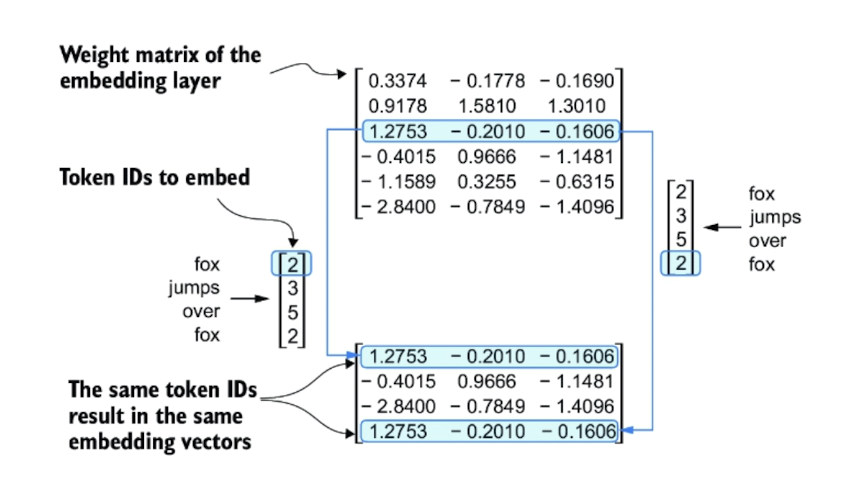

<div class="alert alert-block alert-info">
The embedding layer converts a token ID into the same vector representation regardless of where it is located in the input sequence. For example, the token ID 5, whether it’s in the first or fourth position in the token ID input vector, will result in the same embedding vector.
In theory, using a deterministic, position-independent embedding for the token ID aids in reproducibility. However, since the self-attention mechanism in large language models (LLMs) is inherently indifferent to position, it is beneficial to introduce additional positional information into the LLM.
</div>

<div class="alert alert-block alert-success">
The same token at different points in the sentence will have the same embedding. 
We are not utilizing all the infomration that is present in the sentence. Adding the postional information is helpful.
</div>

<div class="alert alert-block alert-info">
We can use two broad categories of position-aware embeddings: relative positional embeddings and absolute positional embeddings. <br>
<b>Absolute positional embeddings</b> are directly associated with specific positions in a sequence. For each position in the input sequence, a unique embedding is added to the token’s embedding to convey its exact location. For instance, the first token will have a specific positional embedding, the second token another distinct embedding, Consider 2 sentences
The cat sat on the mat.
On the mat the cat sat
For both the sentences the token embedding for cat will be x
However in the first sentence the postional embedding  for cat will be say y but for sentence 2 the positional embedding for cat will be z different from y. So the final embedding for cat for sentence 1 will be x+y , and for sentence 2 will be x+z . This is illustrated in the figure below

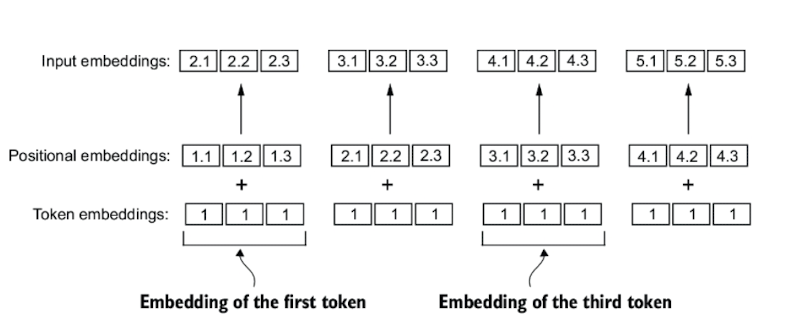

Positional embeddings are added to the token embedding vector to create the input embeddings for an LLM. The positional vectors have the same dimension as the original token embeddings. The token embeddings are shown with value 1 for simplicity.
</div>

<div class="alert alert-block alert-success">
<b> Relative Positional Embedding </b>
    Instead of focusing on the absolute position of a token, the emphasis of relative positional embeddings is on the relative position or distance between tokens. This means the model learns the relationships in terms of “how far apart” rather than “at which exact position.” The advantage here is that the model can generalize better to sequences of varying lengths, even if it hasn’t seen such lengths during training.Relative postion Embedding is used when input sequences are very large.
    The choice between the two depends upon the specific application and the data that is being used. <br>
    <b>Absolute positional encoding </b> is preferred when the fixed order of tokens is crucial such as for sequence generation example for GPT. <br>
    <b>Relative positional encoding </b>on the other hand is suitable for tasks like language modeling or long sequences where the same phrase can appear in different parts of the sequence so generally relative positional encoding is useful if you are analyzing long sequences and where the same phrase can repeat over and over again. <br>
</div>

<div class="alert alert-block alert-info">
    OpenAI’s GPT models use <b> absolute positional embeddings </b> that are optimized during the training process rather than being fixed or predefined like the positional encodings in the original transformer model (The paper provieds another way to get postional encoding using Sinusoidal equations) This optimization process is part of the model training itself. 
</div>

In [26]:
import torch
import importlib
import tiktoken
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [27]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [28]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

<div class="alert alert-block alert-success">
Previously, we focused on very small embedding sizes for simplicity. Now, let’s consider more realistic and useful embedding sizes and encode the input tokens into a 256-dimensional vector representation, which is smaller than what the original GPT-3 model used (in GPT-3, the embedding size is 12,288 dimensions) but still reasonable for experimentation. Furthermore, we assume that the token IDs were created by the BPE tokenizer we implemented earlier, which has a vocabulary size of 50,257:
</div>

In [29]:
import torch
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

## Steps for Generating FINAL o/p

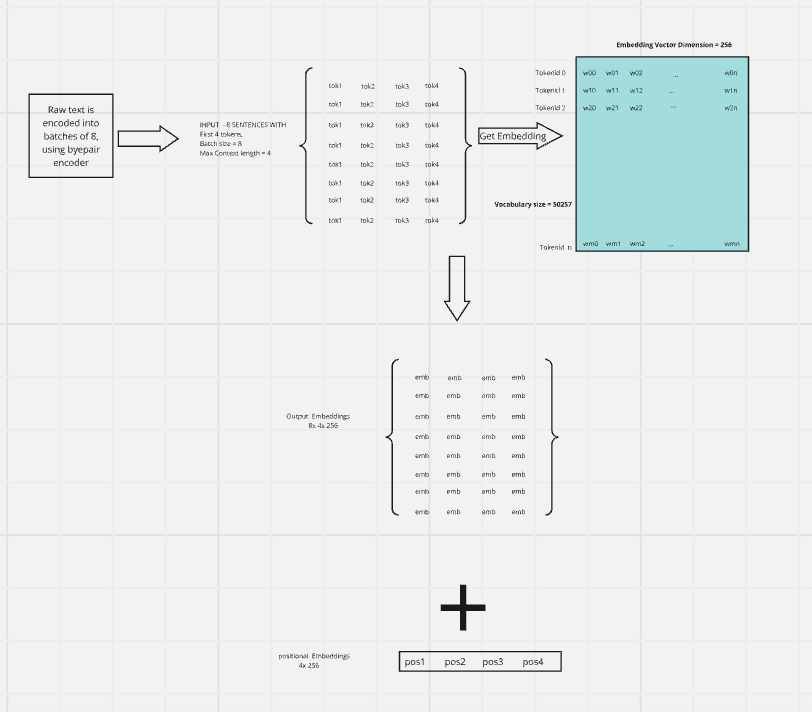

<div class="alert alert-block alert-info">
    
Using the token_embedding_layer above, if we sample data from the data loader, we
embed each token in each batch into a 256-dimensional vector. If we have a batch size of 8
with four tokens each, the result will be an 8 x 4 x 256 tensor.
    
</div>

<div class="alert alert-block alert-success">

Let's instantiate the data loader ( Data sampling with a sliding window),
first:

</div>

In [30]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [31]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[10970, 33310,    35, 18379],
        [  198, 15749, 40417,   198],
        [  198,    40,   550,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  198,   198, 11274,  5891],
        [ 1576,   438,   568,   340]])

Inputs shape:
 torch.Size([8, 4])


<div class="alert alert-block alert-info">
    
As we can see, the token ID tensor is 8x4-dimensional, meaning that the data batch
consists of 8 text samples with 4 tokens each.
    
</div>

<div class="alert alert-block alert-success">

Let's now use the embedding layer to embed these token IDs into 256-dimensional
vectors:

</div>

In [32]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


<div class="alert alert-block alert-info">
    
As we can tell based on the 8x4x256-dimensional tensor output, each token ID is now
embedded as a 256-dimensional vector.
    
</div>

<div class="alert alert-block alert-success">

For a GPT model's absolute embedding approach, we just need to create another
embedding layer that has the same dimension as the token_embedding_layer:

</div>

In [34]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [35]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


<div class="alert alert-block alert-info">
    
As shown in the preceding code example, the input to the pos_embeddings is usually a
placeholder vector torch.arange(context_length), which contains a sequence of
numbers 0, 1, ..., up to the maximum input length − 1. 

The context_length is a variable
that represents the supported input size of the LLM. 

Here, we choose it similar to the
maximum length of the input text. 

In practice, input text can be longer than the supported
context length, in which case we have to truncate the text.
    
</div>

<div class="alert alert-block alert-info">
    
As we can see, the positional embedding tensor consists of four 256-dimensional vectors.
We can now add these directly to the token embeddings, where PyTorch will add the 4x256-
dimensional pos_embeddings tensor to each 4x256-dimensional token embedding tensor in
each of the 8 batches:
    
</div>

In [36]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


<div class="alert alert-block alert-warning">

The input_embeddings we created are the embedded input
examples that can now be processed by the main LLM modules
    
</div>